# SEIRD Data Fitting Model from Henri Froesi for Brazilian States Covid19 - Evolution and Prediction

## References: 

### [1] Modelling Beyond the Basic SIR Model - Henri Froesi - Towards Data Science
#### https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4

### [2] Infectious Disease Modelling. Fitting Your Model to Corona Virus Data - Henri Froesi-Towards Data Science
#### https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

### Adapted by Ivan Carlos P. da Cruz (GitHub @icpcruz)
### Revision and contributions by Eduardo Correa Araújo (GitHub @eduardocorrearaujo)

# Model summary ref. [1]

<img src="SEIRD%20model.png" style="width:600px" />

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 

from scipy.integrate import odeint
# !pip install lmfit - DONE !

import lmfit
from lmfit import Model # classe lmfit para a criação do modelo de fitting

import numdifftools # permite que lmfit calcule a matriz de correlações

import datetime

import warnings
warnings.filterwarnings('ignore')

### Definição da função para R_0(t) como arco-tangente (de 2 parâmetros)

In [2]:
def R_0_atan(t, a, b):
    f = (2/np.pi)*np.arctan(-(t-a)/b)+1
    return f

#### Plot da função arctan para alguns valores dos parâmetros

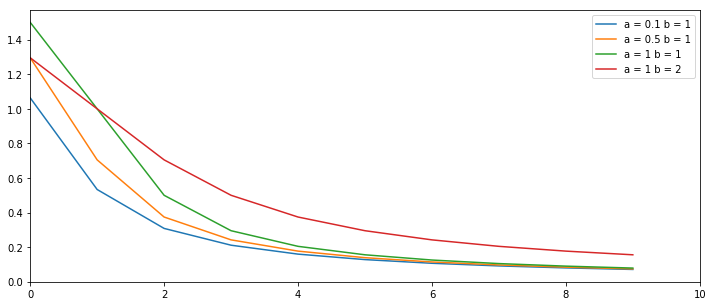

In [28]:
t=np.arange(10)

plt.figure(figsize = [12, 5])
plt.xlim(0,10)
#plt. ylim(0,40)
plt.plot(t,R_0_atan(t, 0.1, 1), label= 'a = 0.1 b = 1')
plt.plot(t,R_0_atan(t, 0.5, 1), label = 'a = 0.5 b = 1')
plt.plot(t,R_0_atan(t, 1.0, 1), label = 'a = 1 b = 1')
plt.plot(t,R_0_atan(t, 1.0, 2), label = 'a = 1 b = 2')
plt.legend()
plt.show()

## Importação de dados de óbitos diários por estado brasileiro (NE)

### Diretório sincronizado com o GitHub dos dados (arquivos csv):

In [4]:
path = "C:/Users/Ivan/Documents/GitHub/googleData/data/"

### Dicionário de nomes dos arquivos de óbitos diários por estado do NE

In [5]:
pref = "ON"
suf  = "_An.csv"
Data_files_names = {
    "Alagoas"    : pref+"AiL"+suf ,
    "Bahia"      : pref+"BiA"+suf ,
    "Ceará"      : pref+"CiE"+suf ,
    "Maranhão"   : pref+"MiA"+suf ,
    "Paraíba"    : pref+"PiB"+suf ,
    "Pernambuco" : pref+"PiE"+suf ,
    "Piauí"      : pref+"PiI"+suf ,
    "RioGrdoN"   : pref+"RiN"+suf ,
    "Sergipe"    : pref+"SiE"+suf
}

### Leitura dos arquivos (atualizados diariamente)

In [6]:
data_ON_AL = pd.read_csv(path+Data_files_names["Alagoas"], sep =",")
data_ON_BA = pd.read_csv(path+Data_files_names["Bahia"], sep =",")
data_ON_CE = pd.read_csv(path+Data_files_names["Ceará"], sep =",")
data_ON_MA = pd.read_csv(path+Data_files_names["Maranhão"], sep =",")
data_ON_PB = pd.read_csv(path+Data_files_names["Paraíba"], sep =",")
data_ON_PE = pd.read_csv(path+Data_files_names["Pernambuco"], sep =",")
data_ON_PI = pd.read_csv(path+Data_files_names["Piauí"], sep =",")
data_ON_RN = pd.read_csv(path+Data_files_names["RioGrdoN"], sep =",")
data_ON_SE = pd.read_csv(path+Data_files_names["Sergipe"], sep =",")

### "Parsing" das datas

In [7]:
format_str = "%Y-%m-%d"
data_ON_AL['Data'] = data_ON_AL['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_BA['Data'] = data_ON_BA['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_CE['Data'] = data_ON_CE['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_MA['Data'] = data_ON_MA['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_PB['Data'] = data_ON_PB['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_PE['Data'] = data_ON_PE['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_PI['Data'] = data_ON_PI['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_RN['Data'] = data_ON_RN['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))
data_ON_SE['Data'] = data_ON_SE['Data'].apply(lambda x:datetime.datetime.strptime(x,format_str))

In [8]:
data_ON_CE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
Data        85 non-null datetime64[ns]
ONCiE_An    85 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [9]:
data_ON_CE.tail()

,Data,ONCiE_An
80,2020-06-05,77.0
81,2020-06-06,75.0
82,2020-06-07,17.0
83,2020-06-08,138.0
84,2020-06-09,189.0


In [10]:
data_ON_CE.describe()

,ONCiE_An
count,85.000000
mean,50.694118
std,60.005560
min,0.000000
25%,4.000000
50%,25.000000
75%,75.000000
max,261.000000


### Definindo as colunas 'Data' como índices

In [11]:
data_ON_AL.set_index('Data')
data_ON_BA.set_index('Data')
data_ON_CE.set_index('Data')
data_ON_MA.set_index('Data')
data_ON_PB.set_index('Data')
data_ON_PE.set_index('Data')
data_ON_PI.set_index('Data')
data_ON_RN.set_index('Data')
data_ON_SE.set_index('Data')
data_ON_CE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
Data        85 non-null datetime64[ns]
ONCiE_An    85 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


## Parâmetros Epidemiológicos Assumidos para a Covid-19 (como universais) p/o SEIRD

In [12]:
#
# VALORES MÉDIOS ASSUMIDOS (ref. https://theconversation.com/how-long-are-you-infectious-when-you-have-coronavirus-135295):
#
num_of_incubation     = 5      # número de dias de incubação da doença (1/delta). 
num_of_infecting_days = 9      # número de dias que um infectado (ativo) infecta outros (= D = 1/gama)
num_to_dead           = 17     # número de dias para evoluir de infectado para óbito (1/rho)
subnotif_index        = 12     # número de vezes que os casos reais de infectados é maior que os notificados
apparent_letality     = 0.065  # taxa aparente de letalidade (% dos notificados que vão a óbito)
#
Epi_days              = 200    # duração arbitrada da pandemia
#
# FREQUÊNCIAS (POR DIA) CORRESPONDENTES
#
alpha = apparent_letality/subnotif_index
delta = 1/num_of_incubation
gamma = 1/num_of_infecting_days  
rho   = 1/num_to_dead
#
print('\n','*** PARÂMETROS EPIDEMIOLÓGICOS ADOTADOS NO MODELO SEIRD:','\n')
print('    Freq de letalidade   (alpha) = {:.3f}'.format(alpha))
print('    Freq de incubação    (delta) = {:.3f}'.format(delta))
print('    Freq de infetividade (gamma) = {:.3f}'.format(gamma))
print('    Freq para óbito      (rho)   = {:.3f}'.format(rho))


 *** PARÂMETROS EPIDEMIOLÓGICOS ADOTADOS NO MODELO SEIRD: 

    Freq de letalidade   (alpha) = 0.005
    Freq de incubação    (delta) = 0.200
    Freq de infetividade (gamma) = 0.111
    Freq para óbito      (rho)   = 0.059


### Dados da população por estado

In [13]:
N_BR ={"Brasil": 210147125, 
             "Nordeste": 
                 {'MA':7075181, 
                  'PI':3273227, 
                  'CE':9132078, 
                  'RN':3506853, 
                  'PB':4018127, 
                  'PE':9557071, 
                  'AL':3337357, 
                  'SE':2298696, 
                  'BA':14873064}, 
             "Norte": 
                 {'RO':1777225, 
                  'AC':881935, 
                  'AM':4144597, 
                  'RR': 605761, 
                  'PA':8602865, 
                  'AP':845731, 
                  'TO':1572866}, 
             "Sudeste": 
                 {'MG':21168791,
                  'ES':4018650, 
                  'RJ':17264943, 
                  'SP':45919049}, 
             "Sul": 
                 {'PR':11433957, 
                  'SC':7164788, 
                  'RS':11377239}, 
             "Centro-Oeste": 
                 {'MS':2778986, 
                  'MT':3484466, 
                  'GO':7018354, 
                  'DF':3015268} }

# Modelo com R_0 (e "beta") dependentes do tempo

### Função sistema de EDOs do modelo SEIRD que é recursivamente chamada pelo solver das ODEs

In [14]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    #
    S, E, I, R, D = y
    #
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    #
    return dSdt, dEdt, dIdt, dRdt, dDdt

### R_0(t) como uma função arctan (com 2 parâmetros a serem ajustados pelo algorítimo de fitting/otimização)

In [15]:
def atan_R_0(t, a, b):
    f = (2/np.pi)*np.arctan(-(t-a)/b)+1
    return f

#### Valores inicias arbitrados dos parâmetros para o processo de otimização dados como tuplas (esperado, mínimo, máximo)

In [16]:
params_init_min_max = {"a": (20, 0.001, 1000.0),
                       "b": (20, 0.001, 1000.0), 
                       }

# Ajuste das curvas R_0(t) e SEIRD a partir dos dados de mortalidade diária

### Definição da função solver do sistema de EDOs do modelo SEIRD que é recursivamente chamada pelo algoritmo de otimização (fitting aos dados) 

In [17]:
def SolverEDOs(days, N, a, b):
    #
    # definição da função beta(t) = R_0(t)*gama
    #
    def beta(t):
        return atan_R_0(t, a, b) * gamma
    #
    # Valores iniciais das variáveid do SEIRD: N-1 (população), 1 exposto, 0 infectado, recuperados ou mortos
    #
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0
    #
    # geração da grid temporal a partir da quantidade de dias informados
    #
    t = np.arange(days)
    #print(t)
    #
    # Integração do sistema de EDOs - o sistema é passado pela função 'deriv' na chamada do solver
    #
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    #
    # Salvando os resultados nas variáveis do sistema
    #
    S, E, I, R, D = ret.T
    #
    # Cálculo de R_0(t)
    #
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    #
    return t, S, E, I, R, D, R_0_over_time

### Estado teste: Maranhão

In [18]:
N = N_BR['Nordeste']['MA']                 # <-- população do estado
y_data = data_ON_MA['ONMiA_An'].to_numpy() # <-- de pandas series para numpy array - ndarray 
x_data = np.arange(len(y_data))            # <-- do dia 1 ao final da série (Python inicia em 'zero', daí o +1)
days   = len(x_data)                       # <-- duração, até "hoje", da pandemia no estado, para o fitting dos parâmetros

### Definição da função de fitting que chama o solver das EDOs

In [19]:
def fitter(x, a, b):
    ret = SolverEDOs(days, N, a, b) # <-- chama a função solver das EDOs (que chama odeint para integrar)
    deaths_fitted = ret[5]                               # <-- óbitos: 6o elem. da tupla (t, S, E, I, R, D, R_0)
    return deaths_fitted[x]                              # <-- retorna vetor com as fatalidades no tempo 

### Criando o modelo de fitting com o pacote 'lmfit' 

In [20]:
# Cria o modelo de fitting passando a função fitter como parâmetro para lmfit 
#
mod = lmfit.Model(fitter)
#
# Criação do vetor de parâmetros para o fitting, incluindo 3 estimativas iniciais (inicial, min, max) p/cada parâmetro
#
for kwarg, (init, mini, maxi) in params_init_min_max.items(): # <-- usa as estimativas fornecidas acima
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
#
# Criação do vetor de parâmetros para o otimizador
#
params = mod.make_params()

### Realizando o fitting

In [21]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

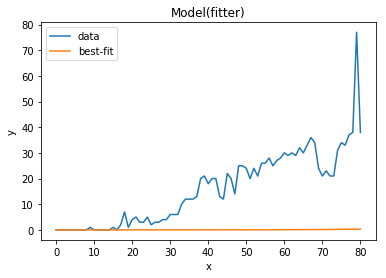

In [22]:
result.plot_fit(datafmt="-");

In [23]:
parametros = []
paramsfit = result.best_values
parametros.append(paramsfit['a'])
parametros.append(paramsfit['b'])

#
print('\n','*** PARÂMETROS OTIMIZADOS DA CURVA ARCO-TANGENTE DE R_0 PELO FITTING COM OS DADOS DE ÓBITOS:','\n')
print('    a = {:.3f}'.format(paramsfit['a']))
print('    b = {:.3f}'.format(paramsfit['b']))


 *** PARÂMETROS OTIMIZADOS DA CURVA ARCO-TANGENTE DE R_0 PELO FITTING COM OS DADOS DE ÓBITOS: 

    a = 1000.000
    b = 0.001


# Plotagem

### Curvas IED (S e R fora de escala nessa fase da pandemia)

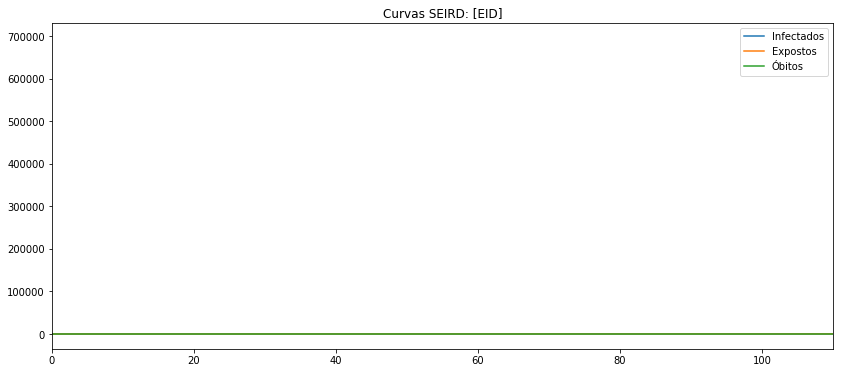

In [24]:
#
# Chamada do SOLVER com os parâmetros otimizados da curva logística para R_0(t)
#
Epi_days = 600
dados = SolverEDOs(Epi_days, N,*parametros)

plt.figure(figsize = [14, 6])
plt.title('Curvas SEIRD: [EID]')
plt.xlim(0,110)
#plt.plot(dados[0],dados[1], label = 'Suscetíveis')
plt.plot(dados[0],dados[2], label = 'Infectados')
plt.plot(dados[0],dados[3], label = 'Expostos')
#plt.plot(dados[0],dados[4], label = 'Recuperados')
plt.plot(dados[0],dados[5], label = 'Óbitos')
plt.legend()
plt.show()

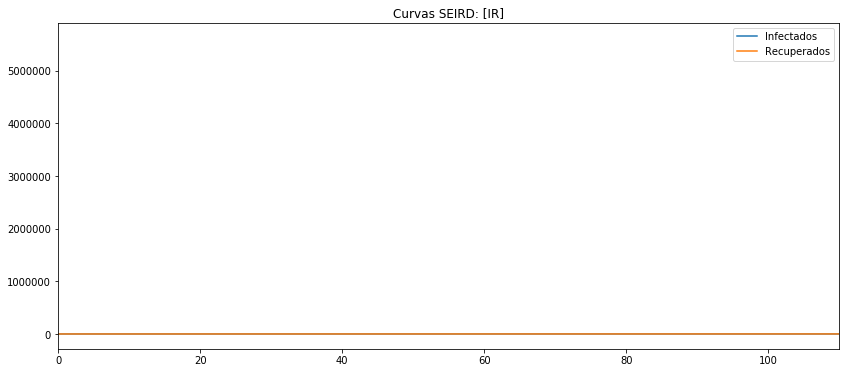

In [25]:
plt.figure(figsize = [14, 6])
plt.title('Curvas SEIRD: [IR]')
plt.xlim(0,110)
#plt.plot(dados[0],dados[1], label = 'Suscetíveis')
plt.plot(dados[0],dados[2], label = 'Infectados')
#plt.plot(dados[0],dados[3], label = 'Expostos')
plt.plot(dados[0],dados[4], label = 'Recuperados')
plt.legend()
plt.show()

### Ajuste da curva estimada de óbitos aos dados

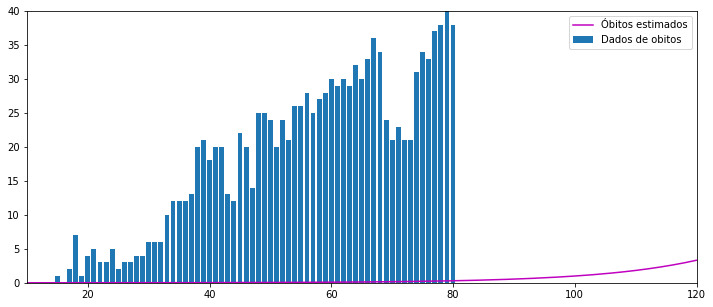

In [26]:
plt.figure(figsize = [12, 5])
plt.xlim(10,120)
plt. ylim(0,40)
plt.plot(dados[0],dados[5], label = 'Óbitos estimados', color='m')
plt.bar(x_data, y_data,     label = 'Dados de obitos')
plt.legend()
plt.show()

### Curva variação de R_0(t)

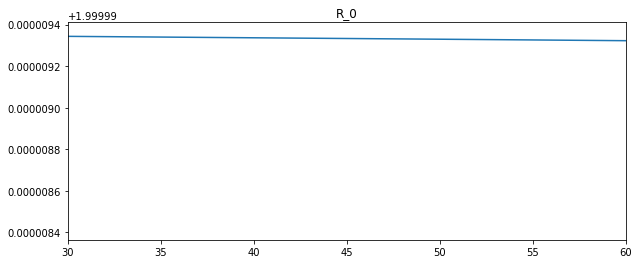

In [27]:
plt.figure(figsize = [10, 4])
plt.xlim(30,60)
plt.title('R_0')
plt.plot(dados[0],dados[6], label = 'R_0')